In [3]:
%matplotlib inline
import re
import os
import numpy as np

import psycopg2
import psycopg2.extras
from itertools import chain
from collections import Counter, defaultdict
import requests
import imageio

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import textwrap
from io import BytesIO
from hashlib import md5
from IPython.display import display, HTML

from itertools import chain
import mwparserfromhell

from keras.models import Model,Sequential
from keras.layers import Embedding, Dense, Input, Lambda, Reshape, merge, Flatten
import keras.backend as K
from keras.layers.merge import Dot
from sklearn.manifold import TSNE

The fetch_image function below fetches an image from wikipedia given a wikipedia id for that image:

In [4]:
OBJ_STR='book'

In [5]:
IMAGE_PATH_EN = 'http://upload.wikimedia.org/wikipedia/en/%s/%s/%s'
IMAGE_PATH_COMMONS = 'http://upload.wikimedia.org/wikipedia/commons/%s/%s/%s'
image_cache = OBJ_STR+'_images'

def fetch_image(image_name):
    if not image_name: 
        return False
    file_path = os.path.join(image_cache, image_name)
    if os.path.isfile(file_path): #if image already exist, simply return 
        #Image.open(file_path).show()
        return True
    else:
        m = md5() #hash function producing 128 bit hash value from text 
        m.update(image_name.encode('utf-8'))
        c = m.hexdigest()
        #print c
        path1 = IMAGE_PATH_EN % (c[0], c[0:2], image_name)
        #print path
        r = requests.get(path1)
        if r.status_code == 404:
            path2 = IMAGE_PATH_COMMONS % (c[0], c[0:2], image_name)
            r = requests.get(path2)
            if r.status_code == 404:
                #print 'status code 404 retrieving ',image_name
                #print 'both paths failed', path1, path2
                return False
        try:
            image = Image.open(BytesIO(r.content))
        except IOError:
            return False
        except ValueError:
            return False
        try:
            image.save(file(file_path, 'w'))
        except IOError as err:
            print image_name, err.message
            return False
        image.thumbnail((240, 640), Image.ANTIALIAS)
        res = BytesIO()
        if image.mode == 'P':
            image = image.convert('RGB')
        try:
            image.save(res, 'WebP', quality=15)
        except IOError as err:
            print image_name, err.message
            return False
        #Image.open(file_path).show()
        return True

fetch_image('TheGreatGatsby_1925jacket.jpeg')

True

In [67]:
postgres_conn = psycopg2.connect('dbname=wikidb user=luliu')
postgres_cursor = postgres_conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

setup a connection to postgres, fetch the 1000 most popular books and then extract for each the book name, the image for the book and the outgoing links from that page

In [7]:
print 'Getting top %ss...'%(OBJ_STR)
postgres_cursor.execute(
    "SELECT wikipedia.*, wikistats.viewcount FROM wikipedia "
    "JOIN wikistats ON wikipedia.title = wikistats.title WHERE wikipedia.infobox like '%book%' "
    "ORDER BY wikistats.viewcount DESC limit 1000"
)
print 'done'

Getting top books...
done


In [8]:
#create an image file for the book if failed to retrieve from the web 
def create_image(title):
    image_name=title.replace(' ','_')+'.jpg'
    file_path = os.path.join(image_cache, image_name)
    if os.path.isfile(file_path): #if image already exist, simply return 
        return image_name
    img = Image.new('RGB', (200, 300))
    draw = ImageDraw.Draw(img)
    draw.text((20, 70), textwrap.fill(title,15) ,font=ImageFont.truetype("/Users/luliu/Library/Fonts/Tox Typewriter.ttf", 20))
    img.save(file_path, "JPEG")  
    return image_name

#turn image name into proper image file name for web retrieval 
def get_clean_image_name(original):
    image_name=original.strip()
    if not image_name:
        return None
    re_image_name=re.compile('([\w\-\(\)\'\.,]+\.(?:jpg|png|jpeg|gif))', re.I|re.M|re.U)
    image_name=image_name.replace(' ','_')
    result=re_image_name.search(image_name)
    if result:
        image_name=result.group().strip("_")
    try:
        if image_name[0].upper()!=image_name[0]: #already capitalized leave untouched
            image_name=image_name.capitalize()
    except:
        print 'has empty image_name string!!!!!!!!!'
    return image_name

item_list = []
for item in postgres_cursor:
    wikicode = mwparserfromhell.parse(item['wikitext'])
    image_name = None
    successful = False #flag for retriveing image online 
    for template in wikicode.filter_templates():
        if template.name.lower().startswith('infobox '):
            for param in template.params:
                key = param.name.strip()                    
                if key == 'image':
                    image_name=get_clean_image_name(param.value) 
                    break
    if image_name:
        successful = fetch_image(image_name)
    if image_name is None or not successful: 
        #print 'cannot find image for ',item['title']
        #print 'creating an image for this item...'
        image_name=create_image(item['title'])
        print image_name, 'created'
    item_list.append((item['title'], image_name, set(unicode(x.title) for x in wikicode.filter_wikilinks()), item['viewcount']))

num_items=len(item_list)
num_items

Guinness_World_Records.jpg created
The_Stranger_(novel).jpg created
Lar_Gand.jpg created
Encyclopædia_Britannica.jpg created
Dirk_Gently's_Holistic_Detective_Agency.jpg created
Katana_(comics).jpg created
A_Bridge_Too_Far_(film).jpg created
Into_the_Wild_(book).jpg created
Tank_Girl.jpg created
Gary_Larson.jpg created
Cat's_Cradle.jpg created
Goosebumps.jpg created
The_History_of_the_Decline_and_Fall_of_the_Roman_Empire.jpg created
Rubaiyat_of_Omar_Khayyam.jpg created
The_Idiot.jpg created
Beyond_Good_and_Evil.jpg created
Magic_Tree_House.jpg created
Little_House_on_the_Prairie.jpg created
Aubrey–Maturin_series.jpg created
The_Devil_and_Daniel_Webster.jpg created
Left_Behind.jpg created
Anabasis_(Xenophon).jpg created
An_Unearthly_Child.jpg created
Liar's_Poker.jpg created
The_Power_of_Myth.jpg created
The_No._1_Ladies'_Detective_Agency.jpg created
The_Rise_and_Fall_of_the_Third_Reich.jpg created
The_Sign_of_the_Four.jpg created
Abi_Titmuss.jpg created
Lady_Susan.jpg created
Master_and

1000

extract all the outgoing links (refs) and keep the ones that are used more than once, less than 50 times (refs that are shared too often does not provide much information).

In [42]:
ref_counts = Counter()
for _, _, refs, _ in item_list:
    ref_counts.update(refs)
all_shared_refs = [ref for ref, count in ref_counts.items() if 1<count<50] #if a ref is shared by too many books, then its not very important 
ref_to_id = {ref: idx for idx, ref in enumerate(all_shared_refs)}
item_to_id = {title: idx for idx, (title, _, _, _) in enumerate(item_list)}
len(all_shared_refs), len(ref_counts)


(12517, 59694)

In [43]:
[ref for ref, count in ref_counts.items() if count>50]

[u'Category:British novels adapted into films',
 u'Time (magazine)',
 u'The New York Times',
 u'science fiction',
 u'Category:American novels adapted into films',
 u'novel',
 u'Soviet Union',
 u'Paperback',
 u'Stephen King',
 u'Hardcover',
 u'hardcover',
 u'United States',
 u'English language',
 u'Category:Debut novels',
 u'Category:Novels adapted into television programs',
 u'World War II',
 u'Internet Archive',
 u'Random House',
 u'protagonist',
 u'New York City',
 u'BBC Radio 4',
 u'paperback',
 u'Science fiction',
 u'Category:Novels first published in serial form',
 u'BBC',
 u'Modern Library',
 u'The Guardian']

In [44]:
#create the book_refs that hold the refs for each book
items_refs = defaultdict(set)
for item, image, refs, viewcounts in item_list:
    item_id = item_to_id[item]
    ref_ids = set(ref_to_id.get(ref) for ref in refs if ref_to_id.get(ref) is not None)
    items_refs[item_id]|=ref_ids
len(items_refs)

1000

In [45]:
#for each ref, the list of books that reference to it 
refs_items = defaultdict(set)
for item_id, ref_ids in items_refs.items():
    for ref_id in ref_ids:
        refs_items[ref_id].add(item_id)
refs_items = list(refs_items.items())
len(refs_items)

12517

check that the most shared refs are meaningful refs

In [46]:
sorted_refs=sorted(refs_items,key=lambda item: len(item[1]),reverse=True)
for id,_ in sorted_refs[:10]:
    print all_shared_refs[id]

HarperCollins
World War I
Entertainment Weekly
comic book
Publishers Weekly
Children's literature
fantasy
American Library Association
The Daily Telegraph
Oxford University Press


generate co-occurence matrix, use jaccard similarity to normalize 
i,j = (#of refs to i and j) /(# of refs to i or j) 

In [48]:
cooccurrence=np.zeros([num_items,num_items])
#todo: could be vectorized 
for i in range(num_items):    
    for j in range(num_items):
        try:
            cooccurrence[i,j]=float((len(items_refs[i]&items_refs[j])))/len(items_refs[i]|items_refs[j])
        except:
            print 'all zeros at',i,j 
            cooccurrence[i,j]=1 #share no references with others
            pass 


In [21]:
#find neighbors in the vector space 
def find_neighbors(M,item_name,k):
    item_id=item_to_id[item_name]
    diff=M-M[item_id]
    distances=np.linalg.norm(diff,axis=1)
    #print distances
    closest=np.argsort(distances)[:k]
    print closest
    for c in closest:
        print c, item_list[c][0],distances[c]


[ 13 292 259 705 530 547 339  92 671 821]
13 Fantastic Beasts and Where to Find Them 0.0
292 The Structure of Scientific Revolutions 0.507223
259 A Feast for Crows 0.53314
705 Our Mutual Friend 0.566518
530 The Castle of Otranto 0.566604
547 The Thorn Birds 0.612004
339 Aubrey–Maturin series 0.619253
92 Murder on the Orient Express 0.636022
671 For Dummies 0.644582
821 What If (comics) 0.64738


In [22]:
def map_to_2d(M):
    model = TSNE(n_components=2, random_state=0)
    return model.fit_transform(M)

1000


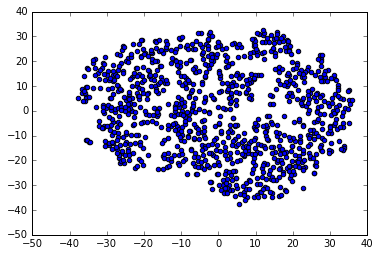

In [23]:
def visualize_data(normalized):
    xy=map_to_2d(normalized)
    print len(xy)
    plt.scatter(xy[:,0], xy[:,1])
    plt.show()
    return xy
xy=visualize_data(normalized)

In [63]:
#create a large bitmap with all the book cover images on it
def generate_giant_poster(poster_name,items,xy):    
    w,h=144,220 #dimensions of a single poster 
    size=50 #use a 50*50 grid to display all 1000 books 
    res=dict()
    #neighbors coordinates for placing overlap images
    NEIGHBORS=[(x,y) for x in range(-1,2) for y in range(-1,2) if not (x==y==0)] 
    x_min = xy.T[0].min()
    y_min = xy.T[1].min()
    x_max = xy.T[0].max()
    y_max = xy.T[1].max()
    img=Image.new('RGB', (size*w,size*h))
    drw=ImageDraw.Draw(img)
    taken=[[False]*(size+1) for _ in range(size+1)] #boolean matrix to keep track of whether a grid is taken
    failure_count=0
    for item, coord in zip(items,xy):
        poster = Image.open(os.path.join(image_cache, item[1]))
        try: 
            poster.thumbnail((w,h),Image.ANTIALIAS) #use a high-quality downsampling filter to resize 
        except IOError as err:
            print err, item[1]
            pass

        x=int(size*(coord[0]-x_min)/(x_max-x_min))
        y=int(size*(coord[1]-y_min)/(y_max-y_min))
        if taken[x][y]:
            found=False
            for dx,dy in NEIGHBORS:
                u,v=x+dx,y+dy
                if 0<=u<=size and 0<=v<=size and not taken[u][v]:
                    x,y=u,v
                    found=True 
                    break
            if not found:
                failure_count+=1
        taken[x][y]=True 
        drw.rectangle((x*w,y*h,(x+1)*w,(y+1)*h),'white')
        res[item[0]]=(x*w,y*h,item[1]) #save the location and size of the poster 
        img.paste(poster,box=(x*w,y*h))
    img.save(open(poster_name+'.png', 'wb'))
    print 'could not find spot for ', failure_count, 'images'
    return res

In [51]:
find_neighbors(cooccurrence,"The Great Gatsby",10) 

[ 11 372 360 809 683 744  16 561 959 107]
11 The Great Gatsby 0.0
372 This Side of Paradise 1.30335070909
360 Tender Is the Night 1.32394881118
809 The House of Mirth 1.37600426038
683 Underworld (DeLillo novel) 1.38566851688
744 An American Tragedy 1.39402468332
16 The Catcher in the Rye 1.39411377387
561 Ethan Frome 1.39497031304
959 Babbitt (novel) 1.39556549092
107 On the Road 1.39745804065


use tsne to project to 2d for visualization 

1000


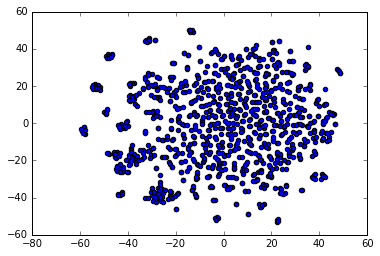

In [50]:
xy=visualize_data(cooccurrence)

In [64]:
res=generate_giant_poster('cooccurrence_to_2d',item_list,xy)

could not find spot for  6 images


write the result back into the database to power the demo on webpage

In [68]:
cursor = postgres_conn.cursor()
cursor.execute('DROP TABLE IF EXISTS book_co_oc_recommender')
cursor.execute('CREATE TABLE book_co_oc_recommender ('
               '    wikipedia_id TEXT PRIMARY KEY,'
               '    image TEXT,'
               '    x FLOAT,'
               '    y FLOAT'
               ')')
cursor.execute('CREATE INDEX book_co_oc_recommender_name_pattern ON book_co_oc_recommender USING btree(lower(wikipedia_id) text_pattern_ops)')


In [69]:
for item_title, (x,y,image_name) in res.items():
    cursor.execute('INSERT INTO book_co_oc_recommender (wikipedia_id, image, x, y) '
                   'VALUES (%s, %s, %s, %s)',(item_title, image_name, x, y))
                             

In [70]:
postgres_conn.commit()
cursor.close()